In [19]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import planck_colormap
import scipy
from scipy import special

cm = planck_colormap.colormap()
%matplotlib inline

In [3]:
import wiener_filter as wf
import mm_constrained_realizations as mmcr

In [11]:
### for testing
### set up - params
nside = 16
lmax = 3*nside//2
npix = hp.nside2npix(nside)
### importing maps
cl = np.load('Commander-Ruler/input_files/cls_PlanckPR2_TT_lowp_lensing_lensed.npy')
noise_cov = hp.read_map('Commander-Ruler/input_files/commander_noise_cov_n16.fits',verbose=False)
mask = hp.read_map('Commander-Ruler/input_files/commander_mask_n16.fits', verbose=False)
weights_map = hp.read_map('Commander-Ruler/input_files/full_weights_map_08_0016.fits', verbose=False)

In [29]:
### see how it behaves as a function of noise_cov
noise_cov[mask ==1] += 100

In [31]:
### generating data to test
signal = hp.synfast(cl,nside, lmax,verbose=False)
noise = np.zeros(npix)
noise[mask==1] = \
np.random.normal(loc=0,scale=1.0,size=(mask==1).sum())*np.sqrt(noise_cov[mask==1])
data = signal + noise
data[mask==0] = hp.UNSEEN

In [32]:
### pixel space set-up

pswf = wf.WienerFilter(nside,mask)
pswf.set_signal_cov(cl)
pswf.set_noise_cov(noise_cov)
pswf.get_wiener_filter()

In [33]:
### messenger method set-up
mmwf = mmcr.ConstrainedRealizations(nside,weights_map,mask=mask)
mmwf.set_signal_cov(cl)
mmwf.set_noise_cov(noise_cov)
mmwf.set_cooling_schedule(1e10,1e-6)

In [34]:
### applying wiener filters
wf_ps = pswf.apply_wiener_filter(data)
wf_mm = hp.alm2map(mmwf.wiener_filter_data(data),nside,lmax,verbose=False)

/home/marcio/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


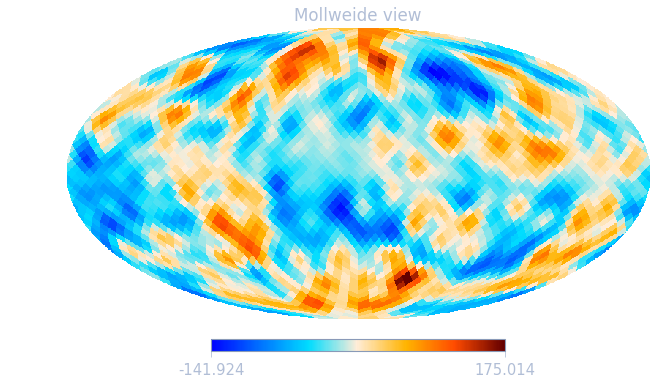

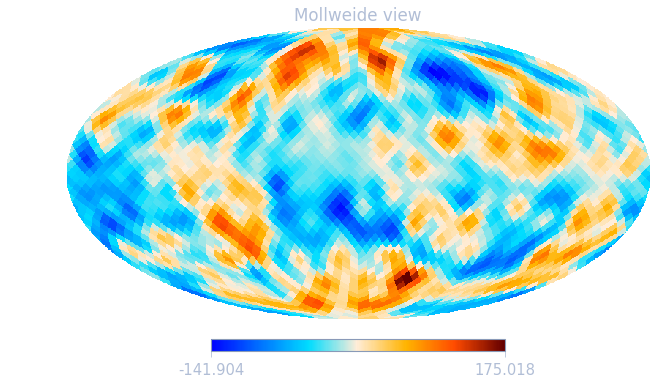

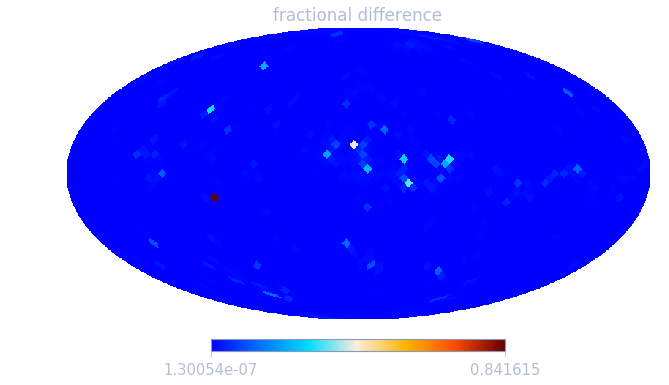

In [35]:
hp.mollview(wf_ps,cmap=cm)
hp.mollview(wf_mm,cmap=cm)
hp.mollview(np.abs(wf_ps-wf_mm)/np.abs(wf_ps),cmap=cm,title='fractional difference')